# Tutorial 3: Classification using simple statistics

---

### Welcome to the next-to-last tutorial

This tutorial will show you how to use python code to implement and evaluate a classification method applied to a dataset (namely, our rooibos data). Current classification methods can be categorized as either (1) basic statistical methods; (2) machine learning; or (3) deep learning. In this notebook, we will use two classical statistical methods: thresholding and  Mahalanobis distance (a mathematical concept invented by the Indian statistician P.C. Mahalanobis in 1936).

Besides using the classification methods, it is also important to evaluate the performance of each method. In many cases, one of the two classes is of particular interest. In such cases there is a tradeoff between positively identifying all instances of this class, and avoiding positives. This tradeoff is expressed in terms of two important concepts (which are explained below):  _recall_ and _precision_. 

When the two classes are equally important, the overall classification accuracy is often used as a measure of performance. As with any parameter estimation, it is important to put error bars on accuracy estimates. For this purpose, we will introduce the "jackknife" method for estimating standard deviations of estimators.  As its name suggests, the jackknive method is a very useful general-purpose tool which can be applied to a wide variety of estimators.  

---

### Overview of the classification problem  in general

The following picture demonstrates the simple idea behind computational classification of objects. The general procedure is:
* Extract features from data;
* Pass the features into a model;
* The model outputs a determination of the sample's class.

<img src="pics/cat.png" width="700" height="300">

In this tutorial we are classifying tea samples, and the  features we will be using are the TPC, TEAC, and FRAP measurements obtained from chemical assays.

To make this work, the programmer must:
* Determine informative features to be used;
* Develop a model that can effectively make use of the features extracted;
* Evaluate the accuracy of the overall system


### Binary classification errors: false positives and false negatives

Binary classification supposes that we are trying to distinguish between two classes, denoted as "null" and "positive". In this case when distinguishing there are two possible errors: false positive or false negative:
  * **[False positive](https://www.statisticshowto.com/false-positive-definition-and-examples/)**: This is where you receive a positive result for a test, when you should have received a negative (null) result. For example, it occurs when a cancer screening test comes back positive, but you don’t have the disease.
  * **[False negative](https://www.statisticshowto.com/false-positive-definition-and-examples/)**: This is where a negative (null) test result is wrong. For example, in the Justice System, a false negative occurs when a guilty suspect is found “not guilty” and allowed to walk free.
  
Based on these definitions, we may define:

   * _False positive rate_: What proportion of positive identifications were actually negatives?
   * _False negative rate_: What proportion of negative idenfications were actually positive?

These two work against each other: decreasing the false positive rate tends to increase the false negative rate.


* False positive rate is related to [specificity  and precision](https://developers.google.com/machine-learning/crash-course/classification/check-your-understanding-accuracy-precision-recall)
* False negative rate is related to [recall and sensitivity](https://developers.google.com/machine-learning/crash-course/classification/check-your-understanding-accuracy-precision-recall)

We will define precision and recall below. Of the four measures mentioned, these are the two that are most often used.

### Classification by threshold, and measures of performance

Often binary classification is based on a single feature (or measurement), or a single quantity calculated from the features of the data sample. If this quantity exceeds a threshold (which is set by the programmer) then the sample is judged to be in one class, and if not the sample is put in the other class.

The following [figure](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall) shows 30 predictions made by an email classification model. Those to the right of the classification _threshold_ are classified as "spam", while those to the left are classified as "not spam."

<img src="pics/preVSrec.svg" width="700" height="200">

where the results can be summaried as follows:

<img src="pics/table.png" width="300" height="150">


From these we may calculate:

* _Precision_ (specificity) measures the percentage of **emails flagged as spam** that were correctly classified—that is, the proportion of all dots to the right of the threshold line that are green in the above figure.
<img src="pics/pre.png" width="350" height="150">
* _Recall_ (sensitivity)  measures the percentage of **actual spam emails** that were correctly classified—that is, the proportion of all green dots that are to the right of the threshold line in the above figure.
<img src="pics/rec.png" width="330" height="160">
* _Accuracy_ gives the overall percentage of correct classifications, and can be calculated  as follows: <br><br>
<img src="pics/acc.png" width="550" height="270">

Different thresholds will give different values for these three measures. 

---

[**Exercise 1:**](https://developers.google.com/machine-learning/crash-course/classification/check-your-understanding-accuracy-precision-recall) Consider a classification model that separates email into two categories: "spam" or "not spam." If you raise the classification threshold, what will happen to precision? What about recall?


---

### Representing performance tradeoffs  with receiver operating characteristic [(ROC)](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc) curves

Receiver operating characteristic (ROC) curves are used to determine thresholds based on the trade-off between false positive error and false negative error. The ROC curve actually shows something slightly different--it represents the proportion of negatives that are _incorrectly_ classified on the x axis versus the proportion of positives that are _correctly_ classified on the y-axis. 

Our example will use code the python packages matplotlib, numpy, and sklearn. We will also make use of some pre-written programs that are located in the `source` directory--these will be imported later.



In [37]:
# ___Cell no. 1___

# Python packages 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import *
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pandas as pd

Recover data


In [38]:
# ___Cell no. 2___

%store -r df_nf
%store -r df_fer
%store -r df

print("Shape of data frame (rows, columns) is: ", df.shape) 

Shape of data frame (rows, columns) is:  (98, 8)


Now, let's look at the imported data

In [39]:
# ___Cell no. 3___

print(df.head(2))

   type    TPC_MEOH    TEAC_MEOH    FRAP_MEOH  TPC_H2O  TEAC_H2O  FRAP_H2O cut
0     0  275.767474  2821.888864  1180.778887   314.33   2588.61    584.61  FC
1     0  253.494375  2355.706326   647.096605   331.41   2818.87    589.91  LL


---

Now let's create arrays for the inputs and outputs. We will separately identify water-based and methanol-based features.

In [40]:
# ___Cell no. 4___

feat_H2O = ['TPC_H2O', 'TEAC_H2O',  'FRAP_H2O'] # define the input (features) for H20
feat_MEOH = ['TPC_MEOH', 'TEAC_MEOH',  'FRAP_MEOH'] # define the input (features) for MeOH

y = df[['type']] # define the output (target)

We consider the case where we are trying to use individual features to distinguish between fermented and nonfermented.  Since we have three different features, for each feature we can set a classification threshold.  The question is:  of these three features, which will give better classification results? We may use the ROC curves associated with each feature to determine this.

We may draw the ROC curves by sorting the data (together with its classification) and counting:

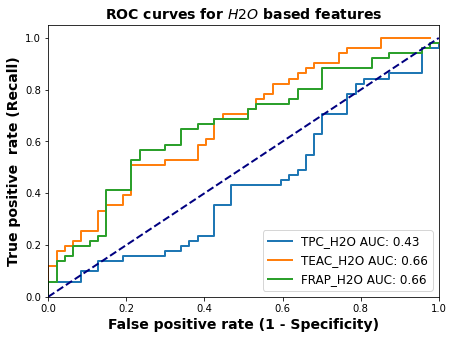

In [41]:
# ___Cell no. 5___

# ROC curves
# True = above threshold is taken as positive, False = above threshold is taken as negative
thrPos =[True,True,True] 
plt.figure(figsize=(7 , 5))
for f, thp in zip(feat_H2O, thrPos):
    xArr = np.array(df[[f]]).flatten()
    nx = len(xArr)
    yArr = np.array(y).flatten()
    # Flip pos/neg labels if negatives are above threshold
    if not(thp):
        yArr = 1-yArr
    # Sort the values in increasing order
    ix = np.argsort(xArr)
    # Sort the corresponding type determination
    ySort= yArr[ix]
    # Running count of number of positives below threshold
    FN = np.cumsum(ySort)
    # Running count of number of negatives below threshold
    TN = np.cumsum(1-ySort)
    # Running count of number of positives above threshold
    TP = np.sum(ySort) - FN
    # Running count of number of negatives above threshold
    FP = np.sum(1-ySort) - TN
    # Proportion of positives that are above the threshold
    TPR = TP/(TP+FN)
    # Propostion of negatives that are above the threshold
    FPR = FP/(TN+FP)
    # Plot FPR (x-axis) versus TPR (y-axis)
    plt.plot(FPR,TPR, lw=2, label = f+" AUC: "+str(round(metrics.auc(FPR, TPR),2)) )

# Plot 45 degree line ('guessing')    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# Set x and y limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# label x and y axes
plt.xlabel('False positive rate (1 - Specificity)', fontweight ='bold', fontsize =14)
plt.ylabel('True positive  rate (Recall)', fontweight ='bold', fontsize =14)
# title and legend
plt.title('ROC curves for $H2O$ based features', fontweight ='bold', fontsize =14)
plt.legend(loc="lower right", prop={"size":12})
plt.show() 




Each line in the above graph shows the true positive and false positive rates for classifiers based on a threshold applied to a single feature.  The $x$ and $y$ values depend on the threshold that is set (the thresholds themselves not shown in the graph--only the rates are shown).  For example, if we use the `TPC_H2O` feature and set the threshold  so that the false positive rate is 0.3 (i.e. the specificity is 1- 0.3 = 0.7), then the true positive rate (recall) is between 0.4 and 0.5. 

The dotted line (which has a slope of 1) corresponds to random guessing:  if you simply make random guesses, then the true and false positive rates will be equal.  A good classifier will have points with large true positive rates and small false positive rate. In other words, the ROC cuve should be *above* the 45 degree line, and the higher the better. The AUC (area under curve) is an overall measure of how high above the 45 degree line the curve is. An AUC value of 0.5 is equivalent to random guessing, while an AUC value of 1 indicates perfect classification (which of courses is rarely possible in practice).  

We can see that some classifiers give an AUC value of less than 0.5.  This means that these classifiers are *worse* than random guessing.  How to solve this problem? Easy--we just reinterpret the threshold so that values _below_ the threshold are classified as positive, and the rest negative.  We can do this in the code by specifying the option `False` for the value of `thrPos` for the corresponding curve. 

---
**Exercise 2:** Copy and change the above code so that all ROC curves lie above the dotted line.
<br>


In [42]:
#  ___ code here ____



---
**Exercise 3:** Make another graph for the three features based on MeOH. Make sure that all curves are above the dotted line.
<br>


In [43]:
#  ___ code here ____



The ROC curve does not actually tell you which threshold to use. Rather, it only tells you what true positive/false positive tradeoffs are possible.  The user will have to decide which tradeoff is most suitable for his situation, and set the threshold accordingly. 

ROC curves are especially useful if you want to compare different classifiers. Classifiers with higher ROC curves are better than classifiers with lower curves.


---
**Exercise 4:** Use the AUC's obtained frm ROC curves to determine which of the 6 individual measurements gives the best classifier.

---

### Mahalanobis distance--a simple classifier based on a calculated distance measure


Simpler is better. Even when applying more advanced ML classification techniques, one should always use a simple method to set a baseline for comparison.  All too often, researchers fail to do this--they may discover too late that their fancy methods are no better than very simple ones.

The simplest classification methods are based on elementary statistics.
One standard statistical classification method uses the so-called [*Mahalanobis distance*](https://en.wikipedia.org/wiki/Mahalanobis_distance). Given an (approximately normal) probability distribution, the Mahalanobis distance of a data point to that distribution uses the covariance matrix of the distribution to estimate the "likelihood" that that data point belongs to the distribution. So if we have two or more distributions and want to assign a data point to one of them, we may choose the distribution that gives the smallest Mahalanobis distance. One big advantage of Mahalanobis distance is that it can be used to classify data based on multiple features (unlike ROC curves, which only work for single-feature classification).

This classification is easy to program in Python. We will demonstrate on our classification of rooibos into fermented and nonfermented. Recall that our data is contained in the dataframe `df`, and the `type` column indicates nonfermented (0) or fermented (1).  We call this our `target output`, and record it in the variable `y`.

In [44]:
# ___Cell no. 6___

y = df[['type']]

Then let us list the feature groups that we will use for classification. Each feature group will give us a different classifier. We will look at three single-feature groups and one with two features.

In [45]:
# ___Cell no. 7___

featureSets = [ ['TPC_H2O'], ['TEAC_H2O'],['FRAP_H2O'], ['TPC_H2O', 'TEAC_H2O']]

At this point, we need to split the data between training data and testing data. The training data is used to  estimate the distribution parameters of fermented and nonfermented. Then, the testing data is used to evaluate the performance of the resulting classifiers.

There is no set rule for choosing the split between training and testing, although generally the training set is larger.  To see which split gives the most reliable classifier, we use <i>jackknife</i> which gives error bars for each estimator's accuracy.  Jackknife works by going through the training/testing process multiple times, each time leaving out one data sample.  This produces multiple accuracy estimates, which can be combined using the "jackknife formula" to obtain an estimate for the variance of the classifier's accuracy.  For more background on the jackknife method, see https://en.wikipedia.org/wiki/Jackknife_resampling. 

First we list the different splits that we will evaluate. Splits are specified according to the proportion of data that is used for testing, while the rest of the data is used for training. 

In [46]:
# ___Cell no. 8___

splits = [0.2,0.4]# Each number gives the proportion of testing data for a particular split

It is convenient to store the results in a *dictionary*.  A dictionary is a Python data structure consisting of key-value pairs. Just like in a regular dictionary, stored values are referenced by keyword, instead of using an index as in lists or arrays. 

In our case, we will create a *nested dictionary*, in which keys are assigned subkeys to label specific information. In our case, the top-level keys indicate the features, second-level keys give the training/testing split, and subkeys indicate different performance results obtained for each estimator.  For more information on nested dictionaries, see: https://www.geeksforgeeks.org/python-nested-dictionary/

First we define an empty dictionary to hold our results.

In [47]:
# ___Cell no. 9___

base_dict = {} 

The following code trains and evaluates 8 classifiers (4 feature sets with 2 splits per feature set).  The code produces the following outputs for each classifier:

* `tot_acc`    : total accuracy;
* `jack_trainSD` : jackknife estimate of standard deviation due to training variation 
* `jack_testSD`  : jackknife estimate of standard deviation due to testing variation


To obtain all these outputs for multiple classifiers, we need some accessory functions.  First we define a function `acc_score_Maha` to compute the accuracy score for a Mahalanobis-distance based classifier with given training and testing sets. The code is below:

In [48]:
# Compute accuracy score for Mahalanobis-based estimator
# xtr, xtst are the training and testing data (dataframe format)
# ytr, ytst are the training and testing labels (dataframe format)
def acc_score_Maha(xtr,ytr,xtst,ytst):
        ncol = len(xtr.columns)
        # First, convert ytr to array to use as an index
        ytr = ytr.to_numpy().flatten()
        
        # Compute M-dist to data 0
        # Select data with label 0
        xtr0 = xtr[ytr==0]
        #Covariance matrix of training data with label 0 
        xtrCov0 = xtr0.cov().to_numpy()
        #Shift of testing data by mean of data with label 0
        xtst0 = (xtst - xtr0.mean(axis=0)).to_numpy().reshape((-1,ncol))
        # Mahalanobis distance of testing data to data with label 0
        mahaDist0 = np.diag(xtst0 @ np.linalg.inv(xtrCov0) @ np.transpose(xtst0))
        
        # Similarly, compute M-dist to data 1
        xtr1 = xtr[ytr==1]
        xtrCov1 = xtr1.cov().to_numpy()
        #Shift of testing data by mean of data with label 1
        xtst1 = (xtst - xtr1.mean(axis=0)).to_numpy().reshape((-1,ncol))
        # Mahalanobis distance of testing data to data with label 1
        mahaDist1 = np.diag(xtst1 @ np.linalg.inv(xtrCov1) @ np.transpose(xtst1))
        
        ## Algorithm determinantion of test set label
        # A `1` is predicted when the distance to label 1 is the smallest; otherwise 0
        yPred = mahaDist1 < mahaDist0
        # Reformat actual labels to compare with predicted
        yActual = ytst.to_numpy().flatten()
        # Return the proportion of correct predictions
        return np.sum(yActual==yPred)/len(yPred)
        

Next, we define a function `get_accuracy_jack` which returns the accuracy score, plus the standard deviations on the accuracy due to training and testing error computed via jackknife using the leave-out-one accuracy scores:

In [49]:
def get_accuracy_jack(xTrain, yTrain, xTest, yTest):
    # Compute accuracy of overall data
    accTot = acc_score_Maha(xTrain, yTrain, xTest, yTest)
    
    # Compute jackknife estimates
    # Need number of estimates to define lists of results
    nxtr = len(yTrain)
    nxte=len(yTest)
    
    # Make space for lists of leave-out-one results
    jackTrainArr = [None]*nxtr
    jackTestArr = [None]*nxte
    
    # Compute accuracies for all leave-out-one train/test sets:
    # leave-out-one for training
    for jtr,itr in enumerate(list(xTrain.index)):
        x_train = xTrain.drop(index=itr)
        y_train = yTrain.drop(index=itr)
        jackTrainArr[jtr] = acc_score_Maha(x_train, y_train, xTest, yTest)
    
    # leave-out-one for testing
    for jte, ite in enumerate(list(xTest.index)):
        x_test = xTest.drop(index=ite)
        y_test = yTest.drop(index=ite)
        jackTestArr[jte] = acc_score_Maha(xTrain, yTrain, x_test, y_test)   
            
    # Compute SD's for error due to training and testing via jackknife formula
    # The total SD is computed using the variance addition formula
    jackTrainSD = np.sqrt((nxtr-1)*np.var(jackTrainArr))
    jackTestSD = np.sqrt((nxte-1)*np.var(jackTestArr))
    jackTotSD = np.sqrt(jackTrainSD**2 + jackTestSD**2)
    
    # Finished! return results
    return  accTot, jackTrainSD, jackTestSD,jackTotSD


Now we're ready to run tests of different splits and features to find the best alternative.  For this purpose, the following code is typical: we will use similar codes to optimize other hyperparameters (a hyperparameter is a number that determines how the algorithm will operate--another example of hyperparameter is learning rate).

In [50]:
# ___Cell no. 10___

# This code computes accuracies for a binary classifier based on Mahalanobis distance
# with different train/test splits
# (https://en.wikipedia.org/wiki/Mahalanobis_distance)
from sklearn.model_selection import train_test_split

# Loop through different splits (use the same splits for all features)
for s in splits:
    # Create training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size= s, random_state=1, stratify = y, shuffle = True)
    # Set the top-level key
    key0 = str(s)
    # Create space for this key to store results
    base_dict[key0] = {}
    # Loop through features
    for f in featureSets:                    
        # Create keys in order to reference results
        key1=str(f) # Creates a top-level key for each estimator
 
        # Call "get_accuracy_jack" function in source to perform train and test
        results = get_accuracy_jack (X_train[f], y_train, X_test[f], y_test) 
        
        # Index results according to sub-keys
        base_dict[key0][key1] = {} # Contains all results for this top-level key
        base_dict[key0][key1]['tot_acc'] = results[0]
        base_dict[key0][key1]['jack_trainSD'] = results[1]
        base_dict[key0][key1]['jack_testSD'] = results[2]
        base_dict[key0][key1]['jack_totSD'] = results[3]
        
        # (optional) print output
        # print(base_dict)
        # print()

We may access different levels of the dictionary by using the keys

In [51]:
# All outputs for a particular split and feature set
print(base_dict["0.4"]["['FRAP_H2O']"]) 
# Individual output item
print(base_dict["0.2"]["['TPC_H2O']"]['jack_trainSD'])

{'tot_acc': 0.75, 'jack_trainSD': 0.278270734473974, 'jack_testSD': 0.0693375245281537, 'jack_totSD': 0.28677917283578536}
0.2573388633655838


We may also display the nested key structure.

In [52]:
# ___Cell no. 12___

print("Top level keys are:\n", base_dict.keys())
# Choose the first key
key0 = list(base_dict.keys())[0]
# Find subkeys under the first key
print("\n Subkeys are:\n",base_dict[key0].keys() )
# Find sub-subkeys
key1 = list(base_dict[key0].keys())[0]
print("\n Sub-subkeys are:\n",base_dict[key0][key1].keys() )


Top level keys are:
 dict_keys(['0.2', '0.4'])

 Subkeys are:
 dict_keys(["['TPC_H2O']", "['TEAC_H2O']", "['FRAP_H2O']", "['TPC_H2O', 'TEAC_H2O']"])

 Sub-subkeys are:
 dict_keys(['tot_acc', 'jack_trainSD', 'jack_testSD', 'jack_totSD'])


We store the dictionary to use in the next notebook.

In [53]:
# ___Cell no. 11___

%store base_dict 

Stored 'base_dict' (dict)


In praparation for plotting, we extrat the accuracy and SD results from the dictionary and put into arrays. We can also print out the results.

In [54]:
# ___Cell no. 13___
class_name = []
acc_arr = [] 
sd_arr = [] 


for key0 in list(base_dict.keys()):
    for key1 in list(base_dict[key0].keys()):
        this_cn = str(key0)+','+str(key1)
        this_acc = base_dict[key0][key1][ 'tot_acc' ]
        this_sd = base_dict[key0][key1]['jack_totSD']
        class_name.append(this_cn)
        acc_arr.append(this_acc) # append total accuarcy to an array
        sd_arr.append(this_sd) # append sd to array of standard deviations

        # (Optional) print accuracy and standard deviation for each classifier
        print( "Classifier name:"+this_cn )
        print( "Estimated accuracy: " + str(this_acc ))
        print("Standard deviation:"+str(this_sd))
        print()

Classifier name:0.2,['TPC_H2O']
Estimated accuracy: 0.5
Standard deviation:0.28174666872055953

Classifier name:0.2,['TEAC_H2O']
Estimated accuracy: 0.7
Standard deviation:0.10513149660756924

Classifier name:0.2,['FRAP_H2O']
Estimated accuracy: 0.7
Standard deviation:0.2281634255061725

Classifier name:0.2,['TPC_H2O', 'TEAC_H2O']
Estimated accuracy: 0.8
Standard deviation:0.0917662935482246

Classifier name:0.4,['TPC_H2O']
Estimated accuracy: 0.55
Standard deviation:0.08996396844211696

Classifier name:0.4,['TEAC_H2O']
Estimated accuracy: 0.675
Standard deviation:0.13291317134775255

Classifier name:0.4,['FRAP_H2O']
Estimated accuracy: 0.75
Standard deviation:0.28677917283578536

Classifier name:0.4,['TPC_H2O', 'TEAC_H2O']
Estimated accuracy: 0.85
Standard deviation:0.05717718748968661



The printed results are hard to interpret. It's much better to visualize using a graph. The `matplotlib` package `errorbar` makes it easy to plot error bars.

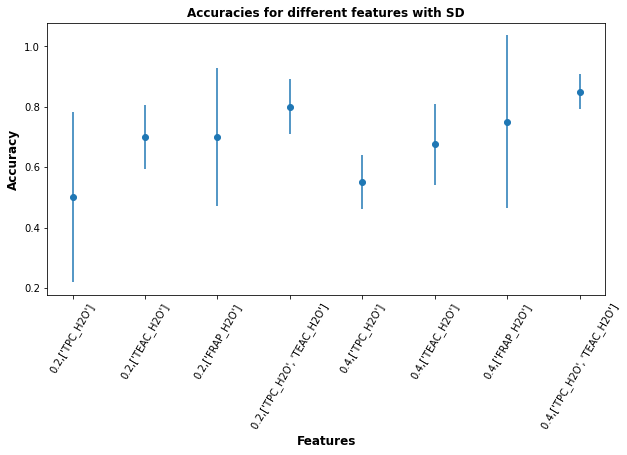

In [55]:
# ___Cell no. 14___

plt.figure(figsize=(10 , 5))
plt.title( "Accuracies for different features with SD", fontweight ='bold', fontsize =12)
plt.xlabel("Features", fontweight ='bold', fontsize =12)
plt.xticks(rotation = 60) # Rotates X-Axis Ticks by 45-degrees
plt.ylabel("Accuracy", fontweight ='bold', fontsize =12)
plt.errorbar( class_name, acc_arr, sd_arr, fmt='o')
plt.show()

**Exercise 5**:  Based on the above graph:
* Which of the better split:  40% testing or 20% testing? Justify your answer.
* Which feature set gives the most accurate classifier? Justify your answer.
---

It is very important to understand the meaning of the error bars. We do not know the actual accuracy of the classifiers: with more training and testing data, the accuracy estimate of any classifier will change. The error bars show the level of uncertainty in each classifier's accuracy.  In other words, if we do a more thorough test with more data, we expect to obtain an accuracy somewhere within the error bars. (We can also reduce the size of the error bars if we do more tests. 

In particular, the above graph shows that the `0.4,['TPC_H20']` classifier is statistically worse than the `0.4,['TPC_H20','TEAC_H20']` classifier because their error bars do not overlap.  On the other hand, although it looks like `0.4,['TPC_H20','TEAC_H20']` is better than `0.4,['FRAP_H20']`, still we cannot conclude that the difference between the two classifiers is statistically significant, because of the large error bars on the accuracy estimate for  `0.4,['FRAP_H20']`.

---
**Challenge**
 1. You have tried splits of 20% and 40%.  With the same features, try to find the best possible split. But don't go over 50%, because there are theoretical reasons that indicate that over 50% cannot be optimal.
2. Repeat the same analysis  (and the same graphs) with the corresponding features using methanol instead of water.
3. Compare water-based versus methanol-based estimators. Which give higher accuracy? Is this consistent?
4. Take the best of the four water-based estimators, and compare with the other two estimators that are based on two features (TPC and FRAP, TEAC and FRAP). Which is the best?
5. Repeat (4) with methanol-based estimators.
5. Which is the overall best estimator of those we've seen so far. 

### _The END of this notebook_
_see you in the next and the last tutorial_

<img src="pics/bam.png" width="300" height="200">
